In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [2]:
base_dir = os.path.dirname(os.getcwd())
sys.path.append(base_dir)

from core.dataloader import CelebALoader
from core.models import VAE, Discriminator, Generator
from core.models import modules
from core.engine import ConfigFile, NCTrainer
from core.metrics import *
data_dir = "../../tmp"

# ./Session

In [3]:
config = ConfigFile("")

In [4]:
config.set_session_name("sandbox_gans")
config.setup_session()

/home/shahine/neural-conditioner/utils/IOHandler.py:25: UserWarning: directory /home/shahine/neural-conditioner/bin/sandbox_gans already exists
  warnings.warn(f"directory {full_path} already exists")
/home/shahine/neural-conditioner/utils/IOHandler.py:25: UserWarning: directory /home/shahine/neural-conditioner/bin/sandbox_gans/chkpt already exists
  warnings.warn(f"directory {full_path} already exists")
/home/shahine/neural-conditioner/utils/IOHandler.py:25: UserWarning: directory /home/shahine/neural-conditioner/bin/sandbox_gans/runs already exists
  warnings.warn(f"directory {full_path} already exists")
/home/shahine/neural-conditioner/utils/IOHandler.py:25: UserWarning: directory /home/shahine/neural-conditioner/bin/sandbox_gans/scores already exists
  warnings.warn(f"directory {full_path} already exists")



# ./Dataloader

In [4]:
transform = transforms.Compose([transforms.Resize((64, 64)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                     std=(0.229, 0.224, 0.225))])

sampler = torch.utils.data.SubsetRandomSampler(indices=np.random.choice(96000, size=96000))

dataloader = CelebALoader(data_dir=data_dir, 
                          batch_size=128,
                          train_transform=transform,
                          val_transform=transform,
                          sampler=sampler,
                          validation_split=0.3)
config.set_dataloader(dataloader)

__Mask Generator :__

In [6]:
masks_kwargs = {'size': (64, 64),
                'coverage': (0.1, 0.5)}

config.update_kwargs(masks=masks_kwargs)

# ./Model

__Generator :__

In [6]:
kwargs = [{'kernel_size': 4, 'bn': False, 'relu': False}] + \
          4 * [{'kernel_size': 4, 'bn': True}] + \
          [{'kernel_size': 4, 'bn': False, 'relu': False}]

generator = Generator(latent_size=(256, 1, 1),
                      nb_filters=[512, 256, 128, 128, 64, 3],
                      conv_kwargs=kwargs)
config.set_model(generator)

In [9]:
chkpt = torch.load("sandbox_gans/chkpt/chkpt_018.pth", map_location=torch.device('cuda:1'))
generator.load_state_dict(chkpt['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


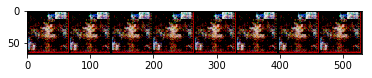

In [16]:
from torchvision.utils import make_grid
z = torch.randn((8, 256, 1, 1))

output = generator(z)
grid = make_grid(output)
plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())

__VAE :__

In [8]:
# vae = VAE(input_size=(6, 64, 64), 
#           z_dim=100, 
#           enc_nf = [64, 128, 128], 
#           dec_nf = [256, 128, 128],
#           enc_kwargs = {'padding': 1},
#           dec_kwargs = {'kernel_size': 4},
#           out_kwargs = {'kernel_size': 4, 'relu': False, 'bn': False},
#           out_channels=3)
# config.set_model(vae)

__Discriminator :__

In [16]:
disc_kwargs = {'input_size': (3, 64, 64),
              'nb_filters': [64, 128],
              'conv_kwargs': {'kernel_size': 4, 'padding': 1, 'stride': 4}}
config.update_kwargs(discriminator=disc_kwargs)

# ./Training params

__Criterion :__

In [10]:
criterion = nn.BCELoss()
config.set_criterion(criterion)

__Optimizers:__

In [11]:
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
disc_optimizer = {'lr': 2e-4,
                  'weight_decay': 1e-7,
                  'betas': (0.5, 0.999)}

config.set_optimizer(gen_optimizer)
config.update_kwargs(disc_optimizer=disc_optimizer)

__Metrics:__

In [12]:
callables = [accuracy, precision, recall]
config.set_metrics(callables)

__Training scope :__

In [13]:
epoch = 128
config.set_epochs(epoch)

In [17]:
config.dump()

In [15]:
!tree -d ../bin

../bin
└── sandbox_gans
    ├── chkpt
    ├── runs
    └── scores

4 directories
